In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

## test
import keras as k

from pathlib import Path

In [10]:
plate_cascade = cv2.CascadeClassifier("./model/haarcascade_russian_plate_number.xml")

In [11]:
default_model = k.models.load_model('model/model_use_ai_based_indian_plate_detection_other.keras')

In [13]:
def resize_image(image, width = None, height = None):

    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = w / h

    if width is None:
        # Calculate height based on the specified width
        new_height = int(height / aspect_ratio)
        resized_image = cv2.resize(image, (height, new_height))
    else:
        # Calculate width based on the specified height
        new_width = int(width * aspect_ratio)
        resized_image = cv2.resize(image, (new_width, width))

    return resized_image

In [40]:
def extract_plate(image):

    plate_img = resize_image(image, width=460)
    roi = plate_img.copy()

    plate = None

    plate_rect = plate_cascade.detectMultiScale(
        plate_img, scaleFactor=1.05, minNeighbors=8, minSize=(12, 4), maxSize=(140, 50)
    )

    for x, y, w, h in plate_rect:
        # Offset of the rectangle
        a, b = (int(0.1 * h), int(0.1 * w))
        aa, bb = (int(0.1 * h), int(0.1 * w))

        plate = roi[y + a : y + h - aa, x + b : x + w - bb, :]

    cv2.rectangle(plate_img, (x + 2, y), (x + w - 3, y + h - 5), (51, 224, 172), 3)

    return plate_img, plate

In [23]:
def find_contours(dimensions: list, img, debug=False):
    i_width_threshold = 6

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:16]

    ii = np.dstack([img] * 3)  ###

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        # if (
        #     intWidth > lower_width
        #     and intWidth < upper_width
        #     and intHeight > lower_height
        #     and intHeight < upper_height
        # ):
        if (
            intWidth >= i_width_threshold
            and intWidth < upper_width
            and intHeight > lower_height
            and intHeight < upper_height
        ):
            x_cntr_list.append(
                intX
            )  # stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44, 24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY : intY + intHeight, intX : intX + intWidth]

            if intWidth >= i_width_threshold and intWidth < lower_width:
                i_char = cv2.resize(
                    char, (intWidth, 42), interpolation=cv2.INTER_LINEAR_EXACT
                )

                char = np.full((42, 22), 255, dtype=np.uint8)
                begin = int((22 - intWidth) / 2)  # center alignment
                char[:, begin : begin + intWidth] = i_char[:, :]
            else:
                char = cv2.resize(char, (22, 42), interpolation=cv2.INTER_LINEAR_EXACT)

            cv2.rectangle(
                ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2
            )
            # if debug:
            plt.imshow(ii, cmap="gray")

            #  Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[1:43, 1:23] = char
            char_copy[0:1, :] = 0
            char_copy[:, 0:1] = 0
            char_copy[43:44, :] = 0
            char_copy[:, 23:24] = 0

            img_res.append(
                char_copy
            )  # List that stores the character's binary image (unsorted)
            # MAY BE
            # if len(img_res) >= 10:
            #     break

    # show_image = Image.fromarray(ii)
    # show_image.show()

    # if debug:
    plt.axis("off")
    plt.show()
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(
            img_res[idx]
        )  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [16]:
def segment_characters(image):

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75), interpolation=cv2.INTER_LINEAR_EXACT)

    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(
        img_gray_lp, 112, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[1]
    LP_HEIGHT = img_binary_lp.shape[0]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    # dimensions = [LP_WIDTH / 24, LP_WIDTH / 2, LP_HEIGHT / 3, 2 * LP_HEIGHT / 3]
    dimensions = [LP_WIDTH/24, LP_WIDTH/2, LP_HEIGHT/3, 2*LP_HEIGHT/3]


    # DEV
    # plt.imshow(img_binary_lp, cmap='gray')
    # plt.axis('off')
    # plt.show()

    # show_image = Image.fromarray(img_binary_lp)
    # show_image.show()

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [17]:
def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img


In [18]:
def predict_license_plate(characters_plate: list, model=None) -> str:

    if model is None:
        model = default_model

    dic = {}
    characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for i, c in enumerate(characters):
        dic[i] = c

    output = []

    for i, ch in enumerate(characters_plate):
        img_ = cv2.resize(ch, (28, 28))
        img_ = fix_dimension(img_)
        img_ = img_.reshape(1, 28, 28, 3)
        y_ = np.argmax(model.predict(img_, verbose=False), axis=-1)[0]
        character = dic[y_]
        output.append(character)

    return "".join(output)

In [19]:
def show_image(image, title=""):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [7]:
path_str = "D:\\project_GoIT\\Python\\Python\\DS-Team\\MakeDataSET\\DATA_SET\\avto"
path_to_images = Path(path_str)

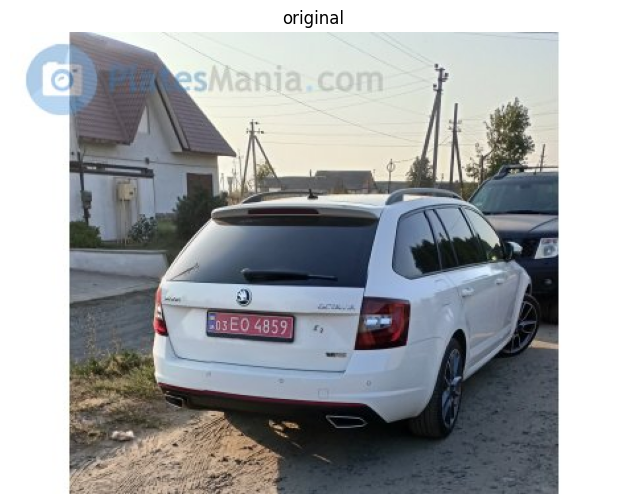

In [41]:
image_file_name = "03 EO 4859.jpg"
img_car_original = cv2.imread(path_to_images / image_file_name)

show_image(img_car_original, "original")

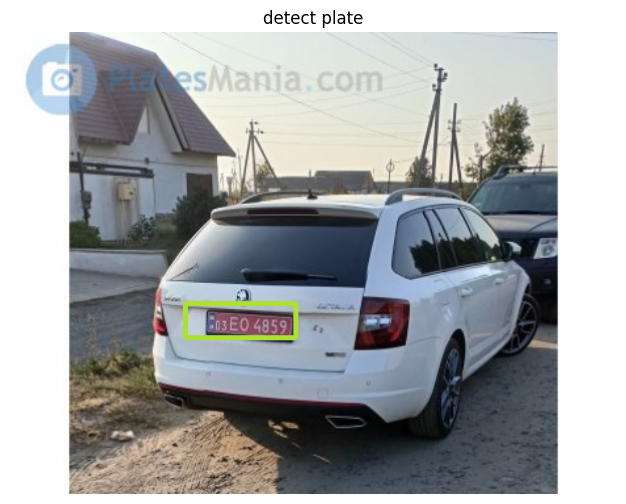

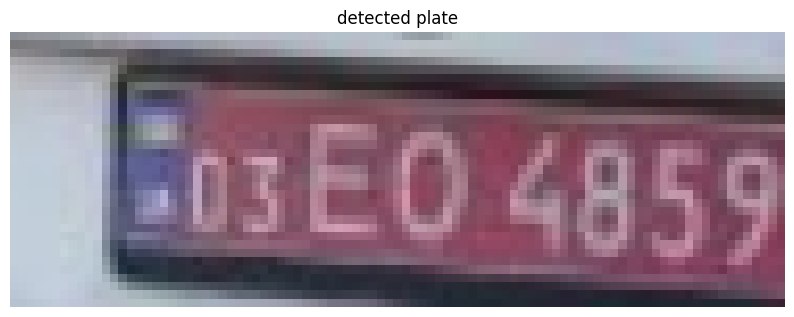

In [42]:

image_with_detect_plate, license_plate = extract_plate(img_car_original)

show_image(image_with_detect_plate, "detect plate")
show_image(license_plate, "detected plate")

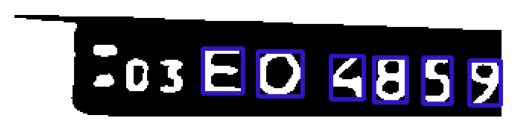

license_plate_predict : WE2RRK


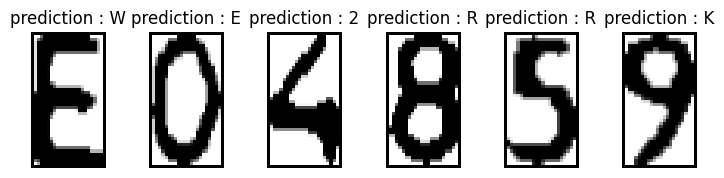

In [43]:
characters_plate = segment_characters(license_plate)

license_plate_predict = predict_license_plate(characters_plate)

print("license_plate_predict :", license_plate_predict)

plt.figure(figsize=(15, 6))
for i in range(len(characters_plate)):
        plt.subplot(3, 10, i+1)
        plt.imshow(characters_plate[i], cmap='gray')
        plt.title(f"prediction : {license_plate_predict[i]}")
        plt.axis('off')
plt.show()